In [1]:
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np

/home/vr-lab/anaconda3/envs/asish_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Convolution function

In [2]:
def convolve2D(image, kernel, xpadding=0, ypadding=0, strides=1):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * xpadding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * ypadding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Padding to All Sides
    if (xpadding != 0) or (ypadding != 0):
        imagePadded = np.zeros((image.shape[0] + xpadding*2, image.shape[1] + ypadding*2))
        if xpadding == 0:
            imagePadded[:, int(ypadding):int(-1 * ypadding)] = image
        elif ypadding == 0:
            imagePadded[int(xpadding):int(-1 * xpadding), :] = image
        else:
            imagePadded[int(xpadding):int(-1 * xpadding), int(ypadding):int(-1 * ypadding)] = image
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > imagePadded.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > imagePadded.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output

### Add noise

In [4]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
      row,col= image.shape
      mean = 120
      var = 100
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col))
      gauss = gauss.reshape(row,col)
      noisy = image + gauss
      return noisy
    elif noise_typ == "snp":
      row,col = image.shape
      s_vs_p = 0.5
      amount = 0.004
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
      out[coords] = 1

      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
      out[coords] = 0
      return out
    elif noise_typ == "poisson":
      vals = len(np.unique(image))
      vals = 2 ** np.ceil(np.log2(vals))
      noisy = np.random.poisson(image * vals) / float(vals)
      return noisy
    elif noise_typ =="speckle":
      row,col = image.shape
      gauss = np.random.randn(row,col)
      gauss = gauss.reshape(row,col)        
      noisy = image + image * gauss
      return noisy

### Generation of image

In [5]:
def gt_gen(height = 512, width = 512, nobj = 4, box_shp = 10):
    img_arr = np.zeros((height, width))

    # white box
    box = np.array([255]*box_shp*box_shp).reshape(box_shp,box_shp)

    for i in range(nobj):
      x = np.random.randint(0,height-box_shp)
      y = np.random.randint(0,width-box_shp)
      img_arr[x:x+box_shp, y:y+box_shp] = box

    img_arr *= 255/img_arr.max()
    
    return img_arr

### Generating real RADAR image

In [6]:
def lr_gen(img_arr, beam_wid_deg = 3.5, sinc_ip_lim=2):
    main_lob_px = int(np.ceil(beam_wid_deg * width / 5))

    # The mail lob width of the sinc (input = -1 to 1) will be contained in main_lob_px points
    # Therefore, we choose an interval -2 to 2, with 10*main_lob_px points

    sinc = np.sinc(np.linspace(-sinc_ip_lim, sinc_ip_lim, sinc_ip_lim * main_lob_px+1))
    # sinc = np.sinc(np.linspace(-1, 1, 200))

    sinc_sq = np.square(sinc)
    sinc_sq = np.expand_dims(sinc_sq, 0)
    # sinc_sq = sinc_sq/np.sum(sinc_sq)
    # print(sinc_sq)
    # print()

    filtered_img = convolve2D(img_arr, sinc_sq, ypadding=(sinc_ip_lim * main_lob_px)//2)
    filtered_img = noisy("gauss", filtered_img)
    # print(filtered_img.max())
    filtered_img *= 255/filtered_img.max()
    
    return filtered_img

### Implementation of all functions

In [7]:
%cd LR-HR_Simulation/Gaussian_noisy

/home/vr-lab/Asish/8th Sem Radar Project/LR-HR_Simulation/Gaussian_noisy


In [8]:
%pwd

'/home/vr-lab/Asish/8th Sem Radar Project/LR-HR_Simulation/Gaussian_noisy'

In [9]:
num = 3000
height, width = 512,512
nobj = {'dense':10, 'sparse':4}
box_shp = 10
beam_wid_deg = 3.5      # This is the sinc function's main lobe width as well
sinc_ip_lim = 2

for sitn in nobj:
    for i in range(num):
#         print(i)
        img_arr = gt_gen(height, width, nobj[sitn], box_shp)
        name_lr = sitn + "/HR/" + sitn + "_hr_" + str(i) + ".jpg"
        cv2.imwrite(name_lr, img_arr)
        filtered_img = lr_gen(img_arr, beam_wid_deg, sinc_ip_lim)
        name_hr = sitn + "/LR/" + sitn + "_lr_" + str(i) + ".jpg"
        cv2.imwrite(name_hr, filtered_img)
        if i%100 == 0:
            print(i, " pairs done")


0  pairs done
100  pairs done
200  pairs done
300  pairs done
400  pairs done
500  pairs done
600  pairs done
700  pairs done
800  pairs done
900  pairs done
1000  pairs done
1100  pairs done
1200  pairs done
1300  pairs done
1400  pairs done
1500  pairs done
1600  pairs done
1700  pairs done
1800  pairs done
1900  pairs done
2000  pairs done
2100  pairs done
2200  pairs done
2300  pairs done
2400  pairs done
2500  pairs done
2600  pairs done
2700  pairs done
2800  pairs done
2900  pairs done
0  pairs done
100  pairs done
200  pairs done
300  pairs done
400  pairs done
500  pairs done
600  pairs done
700  pairs done
800  pairs done
900  pairs done
1000  pairs done
1100  pairs done
1200  pairs done
1300  pairs done
1400  pairs done
1500  pairs done
1600  pairs done
1700  pairs done
1800  pairs done
1900  pairs done
2000  pairs done
2100  pairs done
2200  pairs done
2300  pairs done
2400  pairs done
2500  pairs done
2600  pairs done
2700  pairs done
2800  pairs done
2900  pairs done


(-0.5, 511.5, 511.5, -0.5)

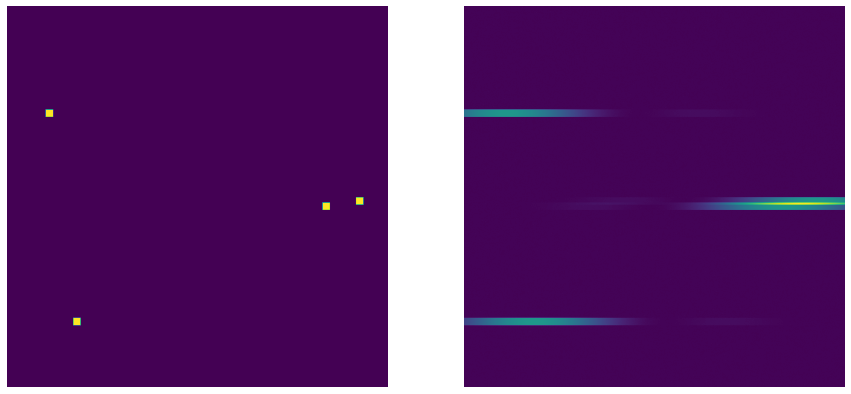

In [10]:
f, axarr = plt.subplots(1,2, figsize=(15,15))
axarr[0].imshow(img_arr)
axarr[0].axis("off")
axarr[1].imshow(filtered_img)
axarr[1].axis("off")

In [ ]:
# recov_img = convolve2D(filtered_img, sinc_sq, ypadding=(sinc_ip_lim * main_lob_px)//2)
# recov_img *= 255/recov_img.max()
recov_img = filtered_img.copy()
# plt.axis("off")
recov_img[recov_img<250] = 0
# print(np.amax(recov_img))
plt.imshow(recov_img)
# recov_img[recov_img1 < 200] = 0


In [ ]:
gauss = np.random.normal(0,1000,(256,256))
gauss = gauss.reshape(256,256)
plt.imshow(gauss)